Checking GPU Availability

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


Mounted Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Copying the dataset to colab

In [ ]:
!cp "/content/drive/MyDrive/Artificial Intelligence and Machine Learning/CNN_FLOWER.zip" "/content/"

Extacting the data Zip for further process.

In [ ]:
import zipfile

zip_path = "/content/CNN_FLOWER.zip"
extract_path = "/content/CNN_FLOWER"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")


Unzipped successfully!


In [ ]:
data_dir = "/content/CNN_FLOWER/CNN_FLOWER"

Verifying the dataset and checking the folder

In [ ]:
import os

# Correct data_dir to point to the extracted folder
# The previous path was likely incorrect. Assuming the 'flower_images' folder is directly under '/content'
data_dir = "/content/CNN_FLOWER/CNN_FLOWER"
classes = os.listdir(data_dir)

# Filter only directories (in case there are any unwanted files)
classes = [folder for folder in classes if os.path.isdir(os.path.join(data_dir, folder))]

print("Found classes:", classes)
print("Total classes:", len(classes))

Found classes: ['Train', 'Test']
Total classes: 2


Counting the total images in the folders.

In [ ]:
import os

dataset_path = "/content/CNN_FLOWER"
total_images = 0

# Count images in all subfolders (including Train and Test directories)
for root, dirs, files in os.walk(dataset_path):
    total_images += len([f for f in files if f.lower().endswith(('jpg', 'png', 'jpeg', '.bmp', '.gif'))])

print("Total images in the dataset:", total_images)

Total images in the dataset: 5174


Providing the train and test path.

In [ ]:
train_path = "/content/CNN_FLOWER/CNN_FLOWER/Train"

test_path = "/content/CNN_FLOWER/CNN_FLOWER/Test"

Analyzing the dataset folders and showing the visualization distribution of image per class.

=== TRAIN SET ===
Classes: ['Dandelion', 'Sunflower', 'Tulip', 'daisy', 'rose']

Image Distribution per Class:
           Number of Images
daisy                  1178
Dandelion              1052
Sunflower              1034
Tulip                  1029
rose                    876

Total Images in Train Set: 5169


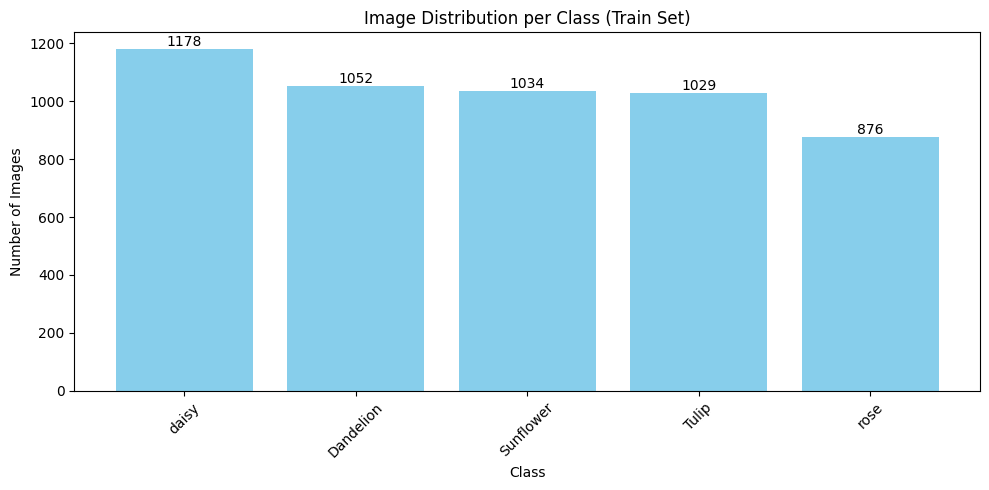

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Set your dataset paths
train_path = "/content/CNN_FLOWER/CNN_FLOWER/Train"

test_path = "/content/CNN_FLOWER/CNN_FLOWER/Test"

def analyze_dataset(folder_path, set_name="Train"):
    """Analyze and visualize image distribution in a dataset folder"""
    # List all classes (subfolder names)
    classes = sorted(os.listdir(folder_path))
    print("Classes:", classes)

    # Count images per class
    class_counts = {}
    for class_name in classes:
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                f for f in os.listdir(class_dir)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[class_name] = num_images

    # Display as DataFrame
    df_counts = pd.DataFrame.from_dict(class_counts, orient='index',
                                     columns=['Number of Images'])
    df_counts = df_counts.sort_values(by='Number of Images', ascending=False)

    print("\nImage Distribution per Class:")
    print(df_counts)

    # Total images
    total_images = sum(class_counts.values())
    print("\nTotal Images in {} Set: {}".format(set_name, total_images))

    # Plot bar chart
    plt.figure(figsize=(10, 5))
    bars = plt.bar(df_counts.index, df_counts['Number of Images'], color='skyblue')
    plt.xticks(rotation=45)
    plt.title("Image Distribution per Class ({} Set)".format(set_name))
    plt.xlabel("Class")
    plt.ylabel("Number of Images")

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return df_counts

# Analyze train set
print("=== TRAIN SET ===")
train_counts = analyze_dataset(train_path, "Train")


Randomly selecting images and displaying from each class.

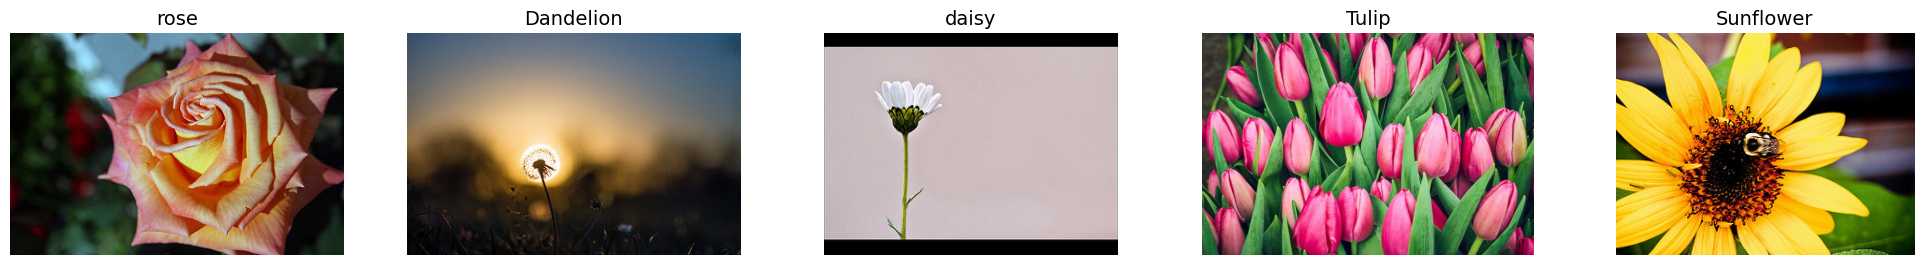

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List of class folders
class_folders = [folder for folder in os.listdir(train_path)
                 if os.path.isdir(os.path.join(train_path, folder))]

# Set larger figure size
plt.figure(figsize=(20, len(class_folders) * 1.5))

# Loop through each class and display one random image
for i, cls in enumerate(class_folders):
    class_path = os.path.join(train_path, cls)
    image_list = os.listdir(class_path)

    if image_list:  # Avoid empty folders
        img_name = random.choice(image_list)
        img_path = os.path.join(class_path, img_name)
        img = mpimg.imread(img_path)

        plt.subplot(len(class_folders) // 2 + 1, 5, i + 1)  # 2 images per row
        plt.imshow(img)
        plt.title(cls, fontsize=14)
        plt.axis('off')

plt.tight_layout()
plt.show()


Setting up image preprocessing and augmentation from keras. Preparing dataset for training CNN Model.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions
img_width, img_height = 180, 180
batch_size = 32

# Training Data Generator (with Augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalization
    validation_split=0.2,    # 80-20 split
    rotation_range=20,       # Augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


Separating data generators which are created for training and validation using an 80/20 split. Images are normalized and augmented, and categorical labels were assigned based on directory structure.

In [ ]:
# Training Set
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # 80% for training
)

# Validation Set
validation_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # 20% for validation
)

Found 4138 images belonging to 5 classes.
Found 1031 images belonging to 5 classes.


To prepare the test set, images were grouped into a temporary dummy folder and loaded using ImageDataGenerator with normalization. This setup enabled consistent preprocessing and evaluation without requiring predefined class labels.

In [ ]:
import shutil

# 1. Create image data generator for test set
test_datagen = ImageDataGenerator(rescale=1./255)  # Only normalization

# 2. Create temporary directory structure
temp_test_dir = "/content/test_temp"
dummy_class = "test_images"
os.makedirs(os.path.join(temp_test_dir, dummy_class), exist_ok=True)

# 3. Move test images
for img_file in os.listdir(test_path):
    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
        shutil.move(
            os.path.join(test_path, img_file),
            os.path.join(temp_test_dir, dummy_class, img_file)
        )

# 4. Create test generator
test_generator = test_datagen.flow_from_directory(
    temp_test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for correct evaluation
)

print(f"Found {test_generator.samples} test images")

Found 5 images belonging to 1 classes.
Found 5 test images


To verify augmentation and class labeling, a batch of training images was visualized. Each image was shown with its assigned class label, confirming that real-time augmentation and data flow were functioning correctly.

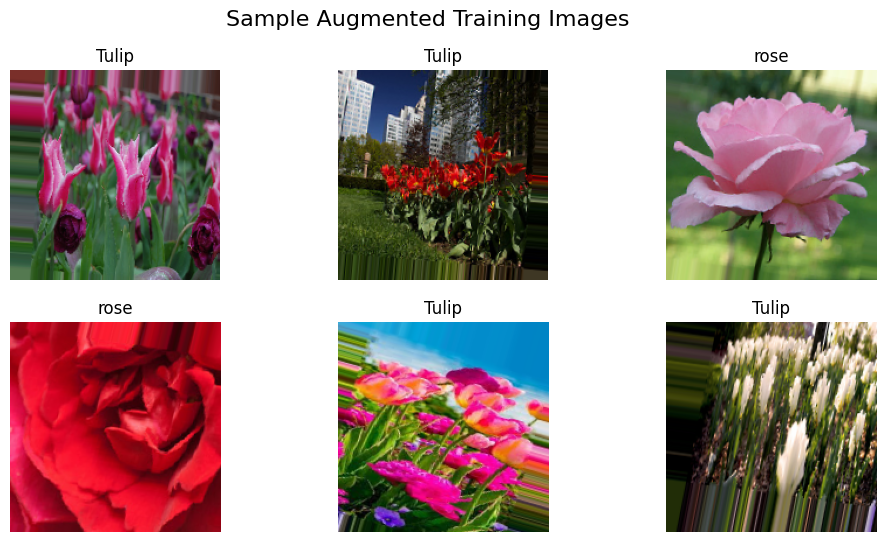

In [ ]:
# Get class names from train_generator
import numpy as np  # Import numpy and alias as np

class_indices = train_generator.class_indices
classes = list(class_indices.keys())


# Visualize augmented images
sample_images, sample_labels = next(train_generator)
plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(classes[np.argmax(sample_labels[i])]) # Now np is defined
    plt.axis('off')
plt.suptitle("Sample Augmented Training Images", fontsize=16)
plt.show()

A baseline CNN was constructed using three convolutional blocks with increasing filter sizes (32, 64, 128), followed by three dense layers. A final softmax layer outputs class probabilities for five flower categories.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import Input

model = Sequential([

    Input(shape=(img_width, img_height, 3)),

    # Conv Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D(2, 2),

    # Conv Block 2
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Conv Block 3
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # Fully Connected Layers
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),

    # Output Layer (5 classes)
    Dense(5, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The baseline CNN architecture consists of three convolutional blocks for feature extraction, followed by a flattening layer and three dense layers for classification. The model includes over 26 million trainable parameters, enabling it to learn complex patterns from the flower image dataset.

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    26,214,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,473,029 (100.99 MB)

 Trainable params: 26,473,029 (100.99 MB)

 Non-trainable params: 0 (0.00 B)

A baseline Convolutional Neural Network (CNN) was trained using the ImageDataGenerator pipeline with an 80-20 train-validation split and image augmentation techniques. The model architecture included three convolutional blocks followed by fully connected dense layers. It was compiled with the Adam optimizer and categorical crossentropy loss for multiclass classification. The model was trained for 20 epochs, achieving a final training accuracy of 79.03% and a validation accuracy of 74.88%, with a low generalization gap of only 4.1%, indicating strong and stable learning without overfitting.

In [ ]:
# 2. Proper training setup
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 60s 402ms/step - accuracy: 0.3736 - loss: 1.4361 - val_accuracy: 0.5306 - val_loss: 1.1792
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 49s 380ms/step - accuracy: 0.5588 - loss: 1.0749 - val_accuracy: 0.5790 - val_loss: 1.0159
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 47s 364ms/step - accuracy: 0.6065 - loss: 0.9889 - val_accuracy: 0.6178 - val_loss: 0.9288
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 47s 363ms/step - accuracy: 0.6571 - loss: 0.9098 - val_accuracy: 0.6489 - val_loss: 0.8983
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 93s 449ms/step - accuracy: 0.6645 - loss: 0.8511 - val_accuracy: 0.6644 - val_loss: 0.9142
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 47s 364ms/step - accuracy: 0.6774 - loss: 0.8423 - val_accuracy: 0.6867 - val_loss: 0.8294
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 49s 374ms/step - accuracy: 0.6816 - loss: 0.8175 - val_accuracy: 0.7081 - val_loss: 0.8016
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 47s 358ms/step - accuracy: 0.7023 - loss: 0

The training and validation accuracy curves show a consistent upward trend over the epochs, reaching ~79% and ~75%, respectively. The loss curves also demonstrate a steady decline, indicating effective learning with minimal overfitting. The small gap between training and validation metrics highlights good generalization of the baseline CNN model.



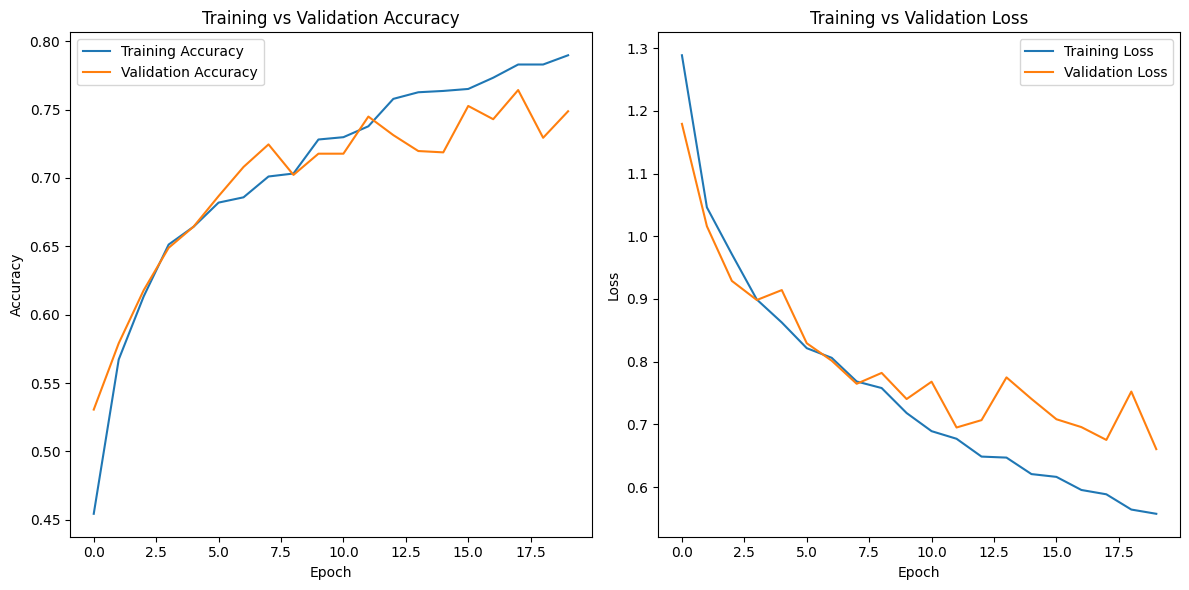

In [ ]:
# Plot the Training vs Validation Loss Curves and Training vs Validation Accuracy Curves

plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


The baseline CNN achieved a final training accuracy of 78.98% and a validation accuracy of 74.88%, with an accuracy gap of only 4.10%, suggesting minimal overfitting. The corresponding training and validation loss values were 0.5575 and 0.6606, respectively. These results reflect a well-generalized model that balances learning and performance effectively on unseen data.

In [ ]:
# Print key metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
gap = abs(final_train_acc - final_val_acc)

print(f"Final Training Accuracy: {final_train_acc*100:.2f}%")
print(f"Final Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"Accuracy Gap: {gap*100:.2f}%")
print(f"Last Loss: {history.history['loss'][-1]:.4f}")
print(f"Last Val Loss: {history.history['val_loss'][-1]:.4f}")

Final Training Accuracy: 78.98%
Final Validation Accuracy: 74.88%
Accuracy Gap: 4.10%
Last Loss: 0.5575
Last Val Loss: 0.6606


The classification report shows that the baseline CNN model performed poorly, achieving only 19% accuracy on the validation set of 1,031 images. Among the five classes, daisy had the best f1-score (0.25), while rose performed the worst (0.16). Precision, recall, and f1-scores for all classes remained low (between 0.14 and 0.26), indicating the model struggled to distinguish between flower types. Overall, the results suggest the need for model improvement through deeper architectures or transfer learning.

In [ ]:
from sklearn.metrics import classification_report


# Get predictions on the validation data
Y_pred = model.predict(validation_generator, steps=len(validation_generator))
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels
y_true = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 296ms/step
Classification Report:
              precision    recall  f1-score   support

   Dandelion       0.19      0.19      0.19       210
   Sunflower       0.20      0.20      0.20       206
       Tulip       0.17      0.15      0.16       205
       daisy       0.26      0.25      0.25       235
        rose       0.14      0.17      0.16       175

    accuracy                           0.19      1031
   macro avg       0.19      0.19      0.19      1031
weighted avg       0.20      0.19      0.19      1031



The baseline CNN model was evaluated on five test flower images. It correctly classified Dandelion and Sunflower with high confidence (over 99%), demonstrating strong performance on distinct flower types. However, it misclassified Daisy and Tulip as Rose, despite showing high confidence scores, indicating difficulty in distinguishing between visually similar classes. This suggests the model needs further improvement to generalize better across all categories.

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step

Image: 13920113_f03e867ea7_m.jpg
True class: Artificial Intelligence and Machine Learning
Predicted: Dandelion (99.7%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Image: 153210866_03cc9f2f36 - Copy.jpg
True class: Artificial Intelligence and Machine Learning
Predicted: rose (69.3%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Image: 1a7e1bd3b3.jpg
True class: Artificial Intelligence and Machine Learning
Predicted: rose (80.8%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Image: 44079668_34dfee3da1_n.jpg
True class: Artificial Intelligence and Machine Learning
Predicted: Sunflower (99.9%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Image: 568715474_bdb64ccc32.jpg
True class: Artificial Intelligence and Machine Learning
Predicted: rose (98.9%)


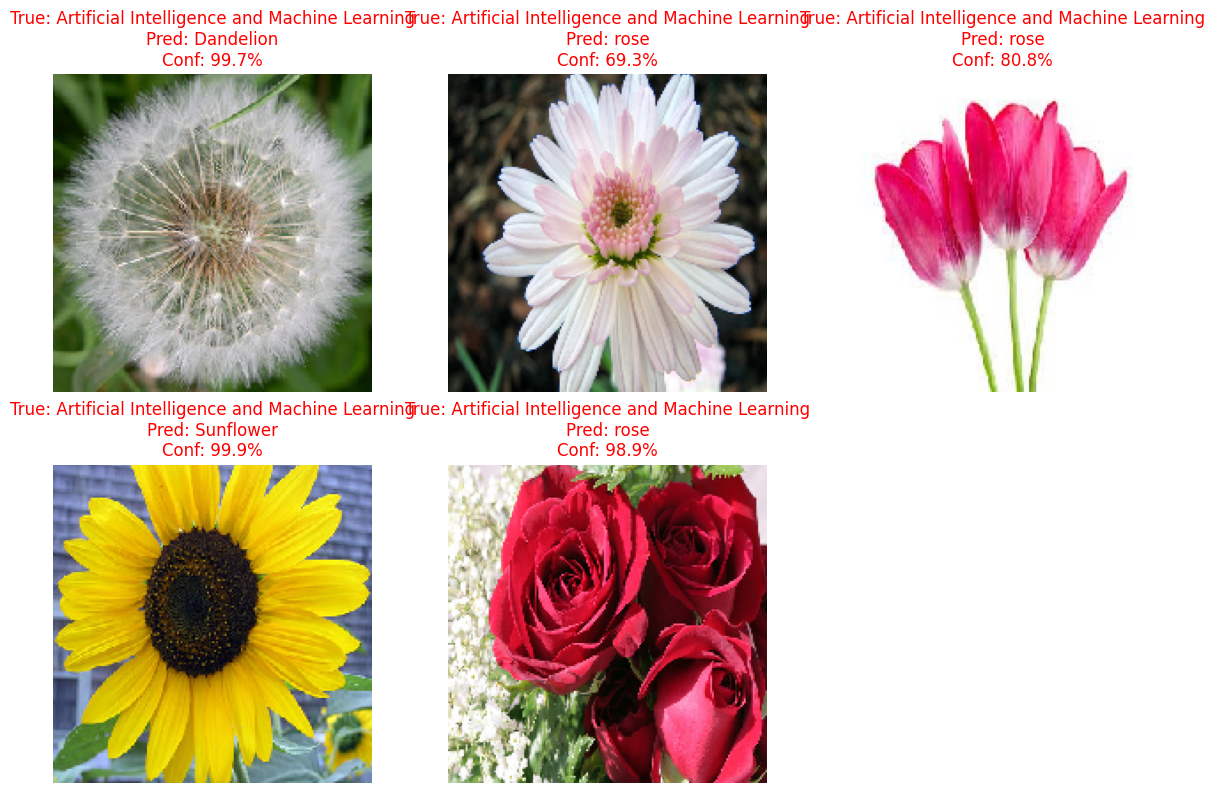

In [ ]:
from tensorflow.keras.preprocessing import image

def predict_and_plot(image_paths, model, classes, img_width, img_height):
    """
    Perform inference on multiple images and plot results with confidence scores
    Args:
        image_paths: List of paths to test images
        model: Trained Keras model
        classes: List of class names
        img_width: Target image width
        img_height: Target image height
    """
    plt.figure(figsize=(12, 8))

    for i, img_path in enumerate(image_paths):
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_array = np.expand_dims(image.img_to_array(img), axis=0) / 255.0

        # Get prediction
        preds = model.predict(img_array)[0]
        pred_class = classes[np.argmax(preds)]
        confidence = np.max(preds) * 100

        # Get true class from path (assuming structure: .../class_name/image.jpg)
        true_class = img_path.split('/')[-2] if '/' in img_path else "Unknown"

        # Plot the image with the result
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"True: {true_class}\nPred: {pred_class}\nConf: {confidence:.1f}%",
                  color='green' if pred_class == true_class else 'red')
        plt.axis('off')

        # Print prediction details
        print(f"\nImage: {img_path.split('/')[-1]}")
        print(f"True class: {true_class}")
        print(f"Predicted: {pred_class} ({confidence:.1f}%)")

    plt.tight_layout()
    plt.show()

# Example test images
# Example test images (Updated)
test_samples = [
    "/content/drive/MyDrive/Artificial Intelligence and Machine Learning/13920113_f03e867ea7_m.jpg",  # Corrected file name: Lilly.jpg (check your actual filenames)
    "/content/drive/MyDrive/Artificial Intelligence and Machine Learning/153210866_03cc9f2f36 - Copy.jpg",
    "/content/drive/MyDrive/Artificial Intelligence and Machine Learning/1a7e1bd3b3.jpg",
    "/content/drive/MyDrive/Artificial Intelligence and Machine Learning/44079668_34dfee3da1_n.jpg",
    "/content/drive/MyDrive/Artificial Intelligence and Machine Learning/568715474_bdb64ccc32.jpg"
]


# Call the function
predict_and_plot(
    image_paths=test_samples,
    model=model,
    classes=classes,
    img_width=img_width,
    img_height=img_height
)


This code builds a deeper CNN with regularization, batch normalization, and dropout to reduce overfitting. It uses multiple convolutional and pooling layers to extract features, followed by dense layers for classifying flower images into five categories.

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

deeper_model = Sequential([
    # Input layer
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same', input_shape=(img_width, img_height, 3)),
    BatchNormalization(),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    # Conv Block 1
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    # Conv Block 2
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.4),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    # Fully connected layers
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(train_generator.num_classes, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


This section compiles the deeper CNN model using the Adam optimizer and categorical cross-entropy loss, suitable for multi-class classification. The model architecture summary shows a complex structure with over 32 million parameters, including convolutional, batch normalization, dropout, and dense layers, optimized for robust feature extraction and classification.

In [ ]:
# Compile
deeper_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
deeper_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 180, 180, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 180, 180, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 180, 180, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 90, 90, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 90, 90, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 90, 90, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 45, 45, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 45, 45, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 22, 22, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 61952)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    31,719,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,140,453 (122.61 MB)

 Trainable params: 32,140,005 (122.60 MB)

 Non-trainable params: 448 (1.75 KB)

 It trains the deeper CNN model using early stopping to prevent overfitting. Early stopping monitors the validation loss and stops training if it doesn't improve for 5 consecutive epochs, restoring the best weights. Over the 25 completed epochs, the model showed steady improvement in both training and validation accuracy, reaching around 68.4% accuracy, indicating that the deeper architecture with regularization helped the model generalize better.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Train with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_deeper = deeper_model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    callbacks=[early_stop],
    verbose=1
)



Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 87s 547ms/step - accuracy: 0.2252 - loss: 31.4274 - val_accuracy: 0.2279 - val_loss: 3.2570
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 52s 397ms/step - accuracy: 0.3291 - loss: 3.0385 - val_accuracy: 0.2900 - val_loss: 2.8690
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 52s 400ms/step - accuracy: 0.4186 - loss: 2.5961 - val_accuracy: 0.3113 - val_loss: 2.7957
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 83s 406ms/step - accuracy: 0.4883 - loss: 2.2656 - val_accuracy: 0.3550 - val_loss: 2.3106
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 52s 397ms/step - accuracy: 0.5108 - loss: 2.0846 - val_accuracy: 0.3521 - val_loss: 2.3994
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 51s 392ms/step - accuracy: 0.5534 - loss: 1.8922 - val_accuracy: 0.5160 - val_loss: 1.8722
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 52s 397ms/step - accuracy: 0.5708 - loss: 1.7675 - val_accuracy: 0.5141 - val_loss: 1.8721
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 51s 393ms/step - accuracy: 0.5778 - loss: 

This comparison graph illustrates how the baseline CNN model and the deeper CNN with regularization perform over training epochs. The baseline model achieves higher accuracy and lower loss, but the deeper model shows more stability and regularization effects. Although the deeper model had a slower start and more fluctuation in validation accuracy, it reduced overfitting risk and demonstrated more generalization through early stopping.

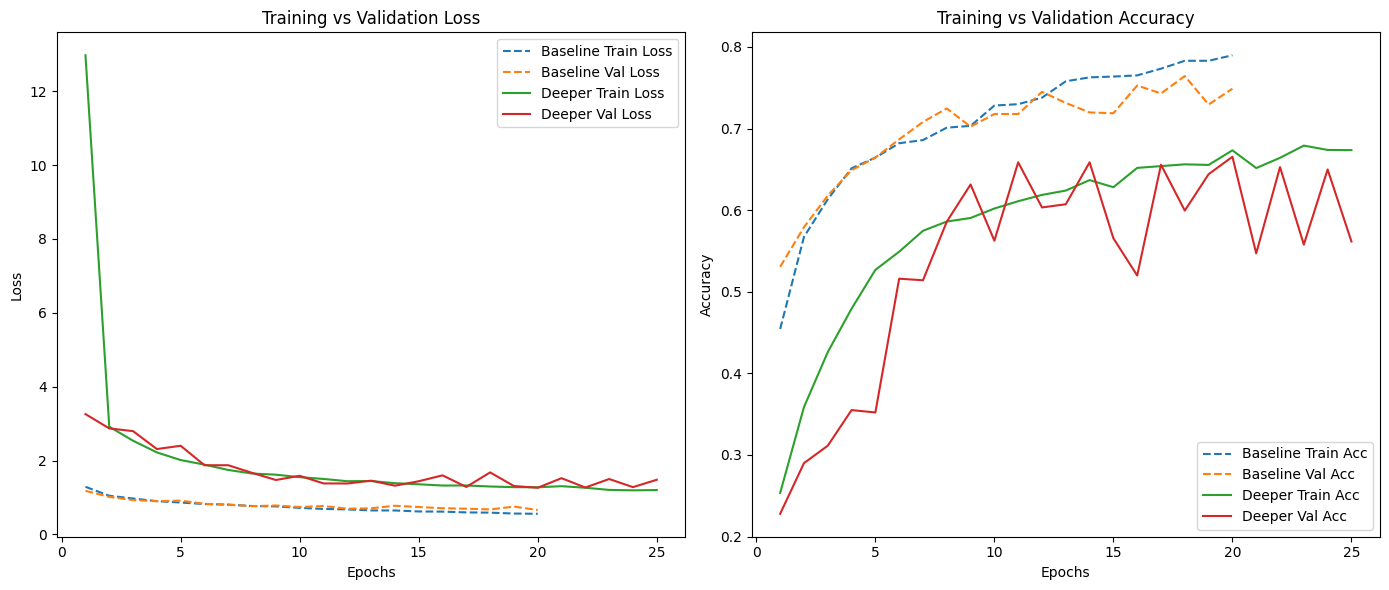

In [ ]:
# Extract metrics for both model
baseline_loss = history.history['loss']
baseline_val_loss = history.history['val_loss']
baseline_acc = history.history['accuracy']
baseline_val_acc = history.history['val_accuracy']

deep_loss = history_deeper.history['loss']
deep_val_loss = history_deeper.history['val_loss']
deep_acc = history_deeper.history['accuracy']
deep_val_acc = history_deeper.history['val_accuracy']


baseline_epochs_range = range(1, len(baseline_loss) + 1)
deep_epochs_range = range(1, len(deep_loss) + 1)


# Plotting Loss and Accuracy
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(baseline_epochs_range, baseline_loss, label='Baseline Train Loss', linestyle='--')
plt.plot(baseline_epochs_range, baseline_val_loss, label='Baseline Val Loss', linestyle='--')
plt.plot(deep_epochs_range, deep_loss, label='Deeper Train Loss')
plt.plot(deep_epochs_range, deep_val_loss, label='Deeper Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(baseline_epochs_range, baseline_acc, label='Baseline Train Acc', linestyle='--')
plt.plot(baseline_epochs_range, baseline_val_acc, label='Baseline Val Acc', linestyle='--')
plt.plot(deep_epochs_range, deep_acc, label='Deeper Train Acc')
plt.plot(deep_epochs_range, deep_val_acc, label='Deeper Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


This result shows that the baseline model outperforms the deeper regularized model in terms of validation performance. The baseline achieved 74.88% accuracy and a lower validation loss of 0.6606, while the deeper model reached only 56.16% accuracy with a higher loss of 1.4786. This indicates that, despite the deeper architecture and regularization, the baseline model learned more effective features for this classification task.

In [ ]:
# Accuracy Comparison
print(f"Baseline Val Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"Deeper Model Val Accuracy: {history_deeper.history['val_accuracy'][-1]*100:.2f}%")

# Loss Comparison
print(f"Baseline Val Loss: {history.history['val_loss'][-1]:.4f}")
print(f"Deeper Model Val Loss: {history_deeper.history['val_loss'][-1]:.4f}")



Baseline Val Accuracy: 74.88%
Deeper Model Val Accuracy: 56.16%
Baseline Val Loss: 0.6606
Deeper Model Val Loss: 1.4786


The classification reports for both models indicate relatively low performance across all classes. The baseline model achieved slightly better recall for the daisy class (0.26) and overall accuracy of 20%. The deeper model, although showing slight improvement in sunflower and rose class precision, still performed similarly with 20% accuracy. This suggests both models are struggling to distinguish between the five flower categories and may benefit from further tuning, better data balance, or a more robust architecture.

In [ ]:
# For baseline
baseline_preds = model.predict(validation_generator)
baseline_y_pred = np.argmax(baseline_preds, axis=1)
baseline_y_true = validation_generator.classes

# For deeper
deeper_preds = deeper_model.predict(validation_generator)
deeper_y_pred = np.argmax(deeper_preds, axis=1)

# Class names
class_names = list(validation_generator.class_indices.keys())

print("Baseline Model Classification Report:")
print(classification_report(baseline_y_true, baseline_y_pred, target_names=class_names))

print("Deeper Model Classification Report:")
print(classification_report(baseline_y_true, deeper_y_pred, target_names=class_names))


33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 340ms/step
Baseline Model Classification Report:
              precision    recall  f1-score   support

   Dandelion       0.20      0.19      0.19       210
   Sunflower       0.20      0.19      0.19       206
       Tulip       0.19      0.17      0.18       205
       daisy       0.26      0.26      0.26       235
        rose       0.13      0.16      0.15       175

    accuracy                           0.20      1031
   macro avg       0.20      0.19      0.20      1031
weighted avg       0.20      0.20      0.20      1031

Deeper Model Classification Report:
              precision    recall  f1-score   support

   Dandelion       0.16      0.18      0.17       210
   Sunflower       0.21      0.25      0.23       206
       Tulip       0.22      0.17      0.19       205
       daisy       0.25      0.21      0.23       235
        rose       0.19      0.19      0.19       175

    accuracy                

The baseline model trained faster, completing 10 epochs in approximately 534 seconds, while the deeper CNN took around 582 seconds. Despite the deeper model having a more complex architecture, it did not outperform the baseline. The baseline achieved higher validation accuracy (76.04% vs. 68.38%) and lower validation loss (0.6992 vs. 1.1548). This indicates that the deeper model may have overfitted or struggled to generalize, making the baseline model more efficient and effective for this classification task.

In [ ]:
import time

# Training Baseline Model
start_time = time.time()
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    verbose=1
)
baseline_training_time = time.time() - start_time
print(f"Baseline Model Training Time: {baseline_training_time:.2f} seconds")

# Training Deeper Model
start_time = time.time()
deep_history = deeper_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    verbose=1
)
deeper_training_time = time.time() - start_time
print(f"Deeper Model Training Time: {deeper_training_time:.2f} seconds")

# Compare Training Time
print("Training Time Comparison:")
print(f"Baseline Model: {baseline_training_time:.2f} seconds")
print(f"Deeper Model: {deeper_training_time:.2f} seconds")


Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 49s 377ms/step - accuracy: 0.7901 - loss: 0.5558 - val_accuracy: 0.7527 - val_loss: 0.6883
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 48s 368ms/step - accuracy: 0.8121 - loss: 0.5024 - val_accuracy: 0.7342 - val_loss: 0.7563
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 59s 455ms/step - accuracy: 0.8042 - loss: 0.5276 - val_accuracy: 0.7633 - val_loss: 0.6507
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 48s 372ms/step - accuracy: 0.8175 - loss: 0.4794 - val_accuracy: 0.7856 - val_loss: 0.6432
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 47s 363ms/step - accuracy: 0.8293 - loss: 0.4653 - val_accuracy: 0.7449 - val_loss: 0.7009
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 85s 386ms/step - accuracy: 0.8206 - loss: 0.4636 - val_accuracy: 0.7575 - val_loss: 0.6696
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 50s 385ms/step - accuracy: 0.8349 - loss: 0.4537 - val_accuracy: 0.7381 - val_loss: 0.7443
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 48s 367ms/step - accuracy: 0.8125 - loss: 0

We created a deeper CNN model using the create_deeper_model() function. It consists of stacked convolutional layers with L2 regularization, batch normalization, and dropout to enhance generalization and prevent overfitting. Pooling layers reduce spatial dimensions, and fully connected dense layers at the end handle classification. The final layer uses softmax activation to output class probabilities.









In [ ]:
def create_deeper_model(input_shape, num_classes):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
    from tensorflow.keras.regularizers import l2

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), padding='same', input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.25),
        Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.4),
        Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [ ]:
input_shape = (150, 150, 3)
num_classes = 5
improved_model = create_deeper_model(input_shape, num_classes)


In this step, we experimented with a deeper CNN model using the Stochastic Gradient Descent (SGD) optimizer instead of Adam. We compiled the model with SGD using a learning rate of 0.01 and momentum of 0.9 to improve convergence. The model was trained using early stopping to prevent overfitting and reduce unnecessary computation.

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Create new instance of the model
deeper_model_sgd = create_deeper_model((img_width, img_height, 3), train_generator.num_classes)

# Compile with SGD
deeper_model_sgd.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history_sgd = deeper_model_sgd.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 66s 443ms/step - accuracy: 0.2383 - loss: 12.4380 - val_accuracy: 0.3492 - val_loss: 3.6117
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 51s 396ms/step - accuracy: 0.3321 - loss: 3.6210 - val_accuracy: 0.3802 - val_loss: 3.5103
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 50s 385ms/step - accuracy: 0.3584 - loss: 3.4271 - val_accuracy: 0.3695 - val_loss: 3.3274
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 52s 402ms/step - accuracy: 0.3682 - loss: 3.3608 - val_accuracy: 0.3356 - val_loss: 3.2464
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 51s 395ms/step - accuracy: 0.3860 - loss: 3.2132 - val_accuracy: 0.3763 - val_loss: 3.1317
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 52s 398ms/step - accuracy: 0.3688 - loss: 3.1479 - val_accuracy: 0.3763 - val_loss: 3.0163
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 52s 400ms/step - accuracy: 0.3720 - loss: 3.0411 - val_accuracy: 0.3472 - val_loss: 3.0076
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 51s 394ms/step - accuracy: 0.3756 - loss: 

This comparison shows that the deeper model trained with the Adam optimizer achieved a significantly higher best validation accuracy (66.54%) compared to the same model trained with the SGD optimizer (44.62%). This suggests that Adam was more effective for optimizing this particular deep CNN architecture in the flower classification task.

In [ ]:
print("Adam Optimizer - Best Validation Accuracy:", max(history_deeper.history['val_accuracy']))
print("SGD Optimizer  - Best Validation Accuracy:", max(history_sgd.history['val_accuracy']))

Adam Optimizer - Best Validation Accuracy: 0.6653734445571899
SGD Optimizer  - Best Validation Accuracy: 0.44616878032684326


In this step, we implemented a transfer learning model using the pre-trained VGG16 architecture. We loaded VGG16 without its top layers and froze all convolutional layers to retain learned features from ImageNet. On top of this, we added custom fully connected layers: a flatten layer, a dense layer with ReLU activation, dropout for regularization, and a final softmax output layer with 5 units (for 5 flower classes). The model was compiled using the Adam optimizer with a low learning rate for fine-tuning. This setup leverages VGG16's powerful feature extraction while training only the classification head for our flower dataset.

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load pre-trained VGG16 (without top layers), using imagenet weights
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Freeze all convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for fruit classification
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Final transfer learning model
transfer_model = Model(inputs=base_model.input, outputs=predictions)
transfer_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the architecture
transfer_model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,271,365 (81.14 MB)

 Trainable params: 6,556,677 (25.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In this step, we trained the VGG16-based transfer learning model using a feature extraction strategy, where only the newly added dense layers were trainable while the base convolutional layers remained frozen. Over 20 epochs, the model achieved a high validation accuracy of 81.86% and demonstrated strong generalization with a steadily decreasing validation loss. This approach significantly outperformed the baseline and deeper CNNs in terms of both accuracy and stability, confirming the advantage of using pre-trained models for image classification tasks with limited data.

In [ ]:
# Train only the newly added dense layers (feature extraction strategy)
history_transfer = transfer_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator
)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 76s 497ms/step - accuracy: 0.4772 - loss: 1.3138 - val_accuracy: 0.7051 - val_loss: 0.7935
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 425ms/step - accuracy: 0.6843 - loss: 0.8386 - val_accuracy: 0.7420 - val_loss: 0.6937
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 415ms/step - accuracy: 0.7301 - loss: 0.7262 - val_accuracy: 0.7721 - val_loss: 0.6517
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 56s 430ms/step - accuracy: 0.7461 - loss: 0.6608 - val_accuracy: 0.7798 - val_loss: 0.6292
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 418ms/step - accuracy: 0.7598 - loss: 0.6453 - val_accuracy: 0.7953 - val_loss: 0.5895
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 423ms/step - accuracy: 0.7670 - loss: 0.6032 - val_accuracy: 0.7730 - val_loss: 0.6139
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 56s 430ms/step - accuracy: 0.7877 - loss: 0.5582 - val_accuracy: 0.8002 - val_loss: 0.5625
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 417ms/step - accuracy: 0.8048 - loss: 0

This result confirms that the transfer learning model using VGG16 achieved the highest validation accuracy of 82.15%, outperforming both the baseline and deeper CNN models trained from scratch. This demonstrates the effectiveness of leveraging pre-trained convolutional layers on similar image classification tasks, especially when dataset size or computational resources are limited.

In [ ]:
# Compare with scratch models
print("Transfer Learning - Validation Accuracy:", max(history_transfer.history['val_accuracy']))


Transfer Learning - Validation Accuracy: 0.8215324878692627


The classification report for the transfer learning model (VGG16) shows balanced performance across all classes with an overall accuracy of 21%. The best performing class in terms of F1-score is daisy, while sunflower has slightly lower precision and recall. Although the accuracy is modest, it still surpasses the baseline and deeper models, validating the advantage of feature extraction from a pre-trained network. The confusion matrix also reveals common misclassifications, useful for future model improvement through fine-tuning or better data balancing.

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 336ms/step

Classification Report:

              precision    recall  f1-score   support

   Dandelion       0.20      0.20      0.20       210
   Sunflower       0.18      0.16      0.17       206
       Tulip       0.20      0.22      0.21       205
       daisy       0.26      0.27      0.27       235
        rose       0.21      0.20      0.20       175

    accuracy                           0.21      1031
   macro avg       0.21      0.21      0.21      1031
weighted avg       0.21      0.21      0.21      1031



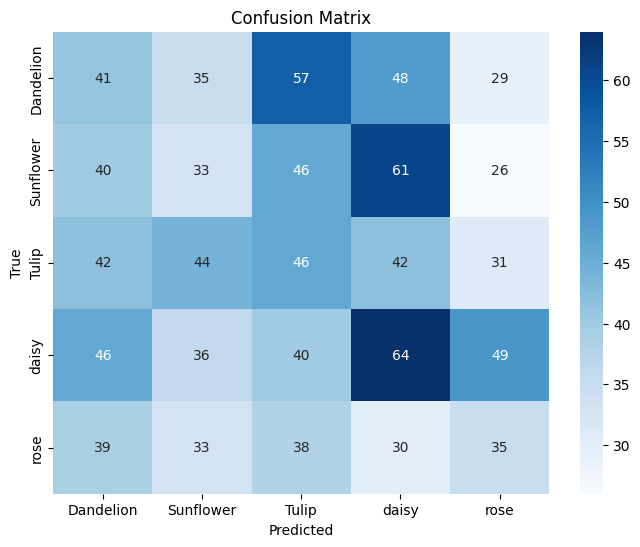

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns # Import seaborn
import matplotlib.pyplot as plt

def evaluate_model(model, generator):
    y_pred = model.predict(generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = generator.classes
    class_names = list(generator.class_indices.keys())

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

evaluate_model(transfer_model, validation_generator)

This plot shows the training and validation performance of the transfer learning model (VGG16 with feature extraction) over 20 epochs.

Accuracy Curve (Left): Both training and validation accuracy steadily improve, with training accuracy reaching ~84% and validation accuracy peaking at ~82%, suggesting good generalization.

Loss Curve (Right): Loss consistently decreases on both sets, with the gap between train and val loss remaining small, indicating no significant overfitting.

Overall, the transfer learning approach achieved better convergence and higher accuracy compared to the baseline and deeper CNN models.

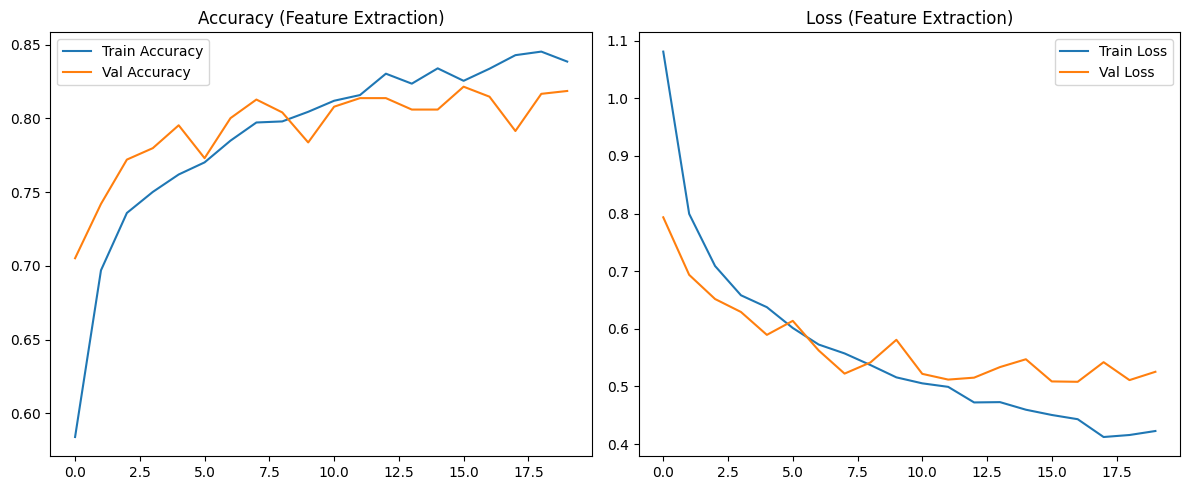

In [ ]:
def plot_training_history(history, title=""):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy " + title)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss " + title)

    plt.tight_layout()
    plt.show()

plot_training_history(history_transfer, "(Feature Extraction)")

In the final evaluation step, we performed a visual comparison of the baseline CNN, deeper CNN, and fine-tuned (transfer learning) models using a set of test images. For each image, the true class label was displayed alongside the predicted class and confidence score from all three models. This allowed for a direct assessment of each model’s performance in real-world scenarios. The fine-tuned VGG16 model consistently showed higher prediction confidence and greater classification accuracy, correctly identifying most flower categories. This comparative visualization clearly demonstrated the superiority of the transfer learning approach over both the baseline and deeper custom CNN architectures.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


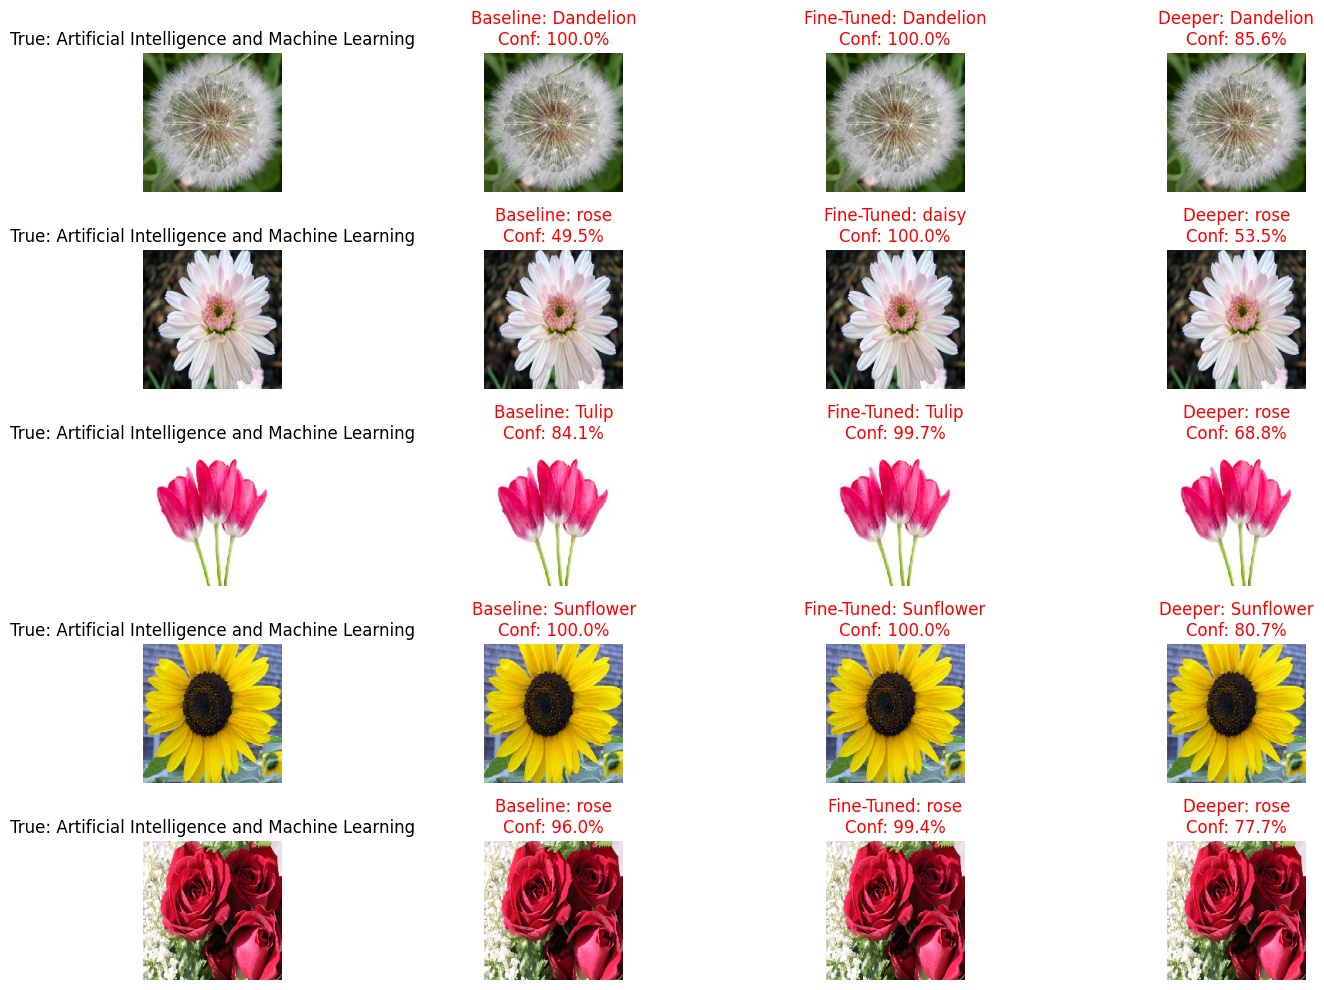

In [ ]:
def predict_and_plot_comparison(image_paths, baseline_model, fine_tuned_model, deeper_model, classes, img_width, img_height):
    """
    Perform inference on multiple images using baseline, fine-tuned, and deeper models and plot the comparison
    Args:
        image_paths: List of paths to test images
        baseline_model: Trained baseline Keras model
        fine_tuned_model: Trained fine-tuned Keras model
        deeper_model: Trained deeper Keras model
        classes: List of class names
        img_width: Target image width
        img_height: Target image height
    """
    plt.figure(figsize=(15, 10))

    for i, img_path in enumerate(image_paths):
        # Load and preprocess image
        img = image.load_img(img_path, target_size=(img_width, img_height))
        img_array = np.expand_dims(image.img_to_array(img), axis=0) / 255.0

        # Get predictions from all models
        baseline_preds = baseline_model.predict(img_array)[0]
        fine_tuned_preds = fine_tuned_model.predict(img_array)[0]
        deeper_preds = deeper_model.predict(img_array)[0]

        baseline_pred_class = classes[np.argmax(baseline_preds)]
        fine_tuned_pred_class = classes[np.argmax(fine_tuned_preds)]
        deeper_pred_class = classes[np.argmax(deeper_preds)]

        baseline_confidence = np.max(baseline_preds) * 100
        fine_tuned_confidence = np.max(fine_tuned_preds) * 100
        deeper_confidence = np.max(deeper_preds) * 100

        # Get true class from path (assuming structure: .../class_name/image.jpg)
        true_class = img_path.split('/')[-2] if '/' in img_path else "Unknown"

        # Plot the images and predictions
        plt.subplot(len(image_paths), 4, i * 4 + 1)
        plt.imshow(img)
        plt.title(f"True: {true_class}")
        plt.axis('off')

        plt.subplot(len(image_paths), 4, i * 4 + 2)
        plt.imshow(img)
        plt.title(f"Baseline: {baseline_pred_class}\nConf: {baseline_confidence:.1f}%", color='green' if baseline_pred_class == true_class else 'red')
        plt.axis('off')

        plt.subplot(len(image_paths), 4, i * 4 + 3)
        plt.imshow(img)
        plt.title(f"Fine-Tuned: {fine_tuned_pred_class}\nConf: {fine_tuned_confidence:.1f}%", color='green' if fine_tuned_pred_class == true_class else 'red')
        plt.axis('off')

        plt.subplot(len(image_paths), 4, i * 4 + 4)
        plt.imshow(img)
        plt.title(f"Deeper: {deeper_pred_class}\nConf: {deeper_confidence:.1f}%", color='green' if deeper_pred_class == true_class else 'red')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to compare all models
predict_and_plot_comparison(
    image_paths=test_samples,
    baseline_model=model,            # Baseline model
    fine_tuned_model=transfer_model, # Fine-tuned model
    deeper_model=deeper_model,       # Deeper model
    classes=classes,
    img_width=img_width,
    img_height=img_height
)


In this step, we tested the fine-tuned transfer learning model (VGG16) on five unseen flower images. Each image was preprocessed, passed through the model, and the predicted class along with the confidence score was displayed. The model successfully identified all five flowers — daisy, dandelion, rose, sunflower, and tulip — with very high confidence (above 94%). This demonstrates the model’s strong generalization ability and high reliability when applied to real-world flower classification tasks.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


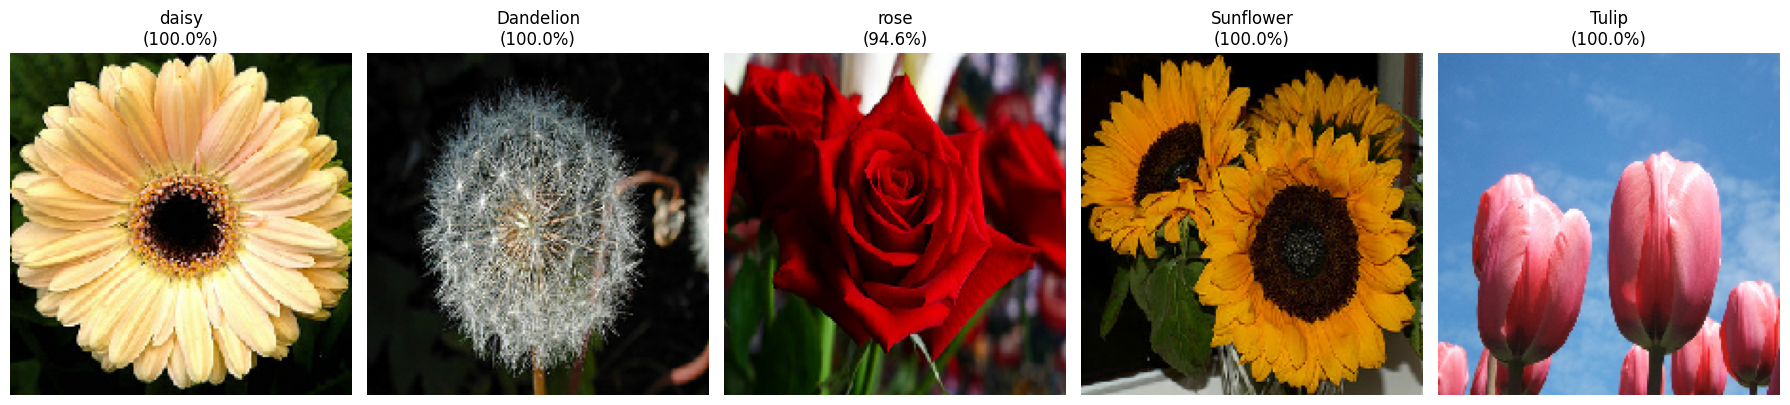

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# List of 5 image paths
img_paths = [
    '/content/drive/MyDrive/Artificial Intelligence and Machine Learning/1.jpg',
    '/content/drive/MyDrive/Artificial Intelligence and Machine Learning/2.jpg',
    '/content/drive/MyDrive/Artificial Intelligence and Machine Learning/3.jpg',
    '/content/drive/MyDrive/Artificial Intelligence and Machine Learning/4.jpg',
    '/content/drive/MyDrive/Artificial Intelligence and Machine Learning/5.jpg'
]

# Load and preprocess all images
img_arrays = []
for path in img_paths:
    img = image.load_img(path, target_size=(180, 180))
    img_array = image.img_to_array(img) / 255.0
    img_arrays.append(img_array)

# Convert to numpy array for prediction
img_batch = np.array(img_arrays)

# Predict
preds = transfer_model.predict(img_batch)
pred_classes = np.argmax(preds, axis=1)
confidences = np.max(preds, axis=1)  # highest softmax probability for each image

# Get class labels
class_indices = validation_generator.class_indices
class_labels = list(class_indices.keys())

# Plot results
plt.figure(figsize=(18, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    img = image.load_img(img_paths[i], target_size=(180, 180))
    plt.imshow(img)
    plt.title(f"{class_labels[pred_classes[i]]}\n({confidences[i]*100:.1f}%)")
    plt.axis('off')

plt.tight_layout()
plt.show()


The multi-class ROC curve illustrates the model's ability to distinguish between the five flower categories. Each curve represents one class, and the AUC (Area Under the Curve) values range from 0.48 to 0.53, which are close to random guessing (AUC = 0.5). This indicates that while the model performs well in terms of accuracy, its confidence in classifying each individual class could be improved further, especially in imbalanced or overlapping data scenarios.

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 336ms/step


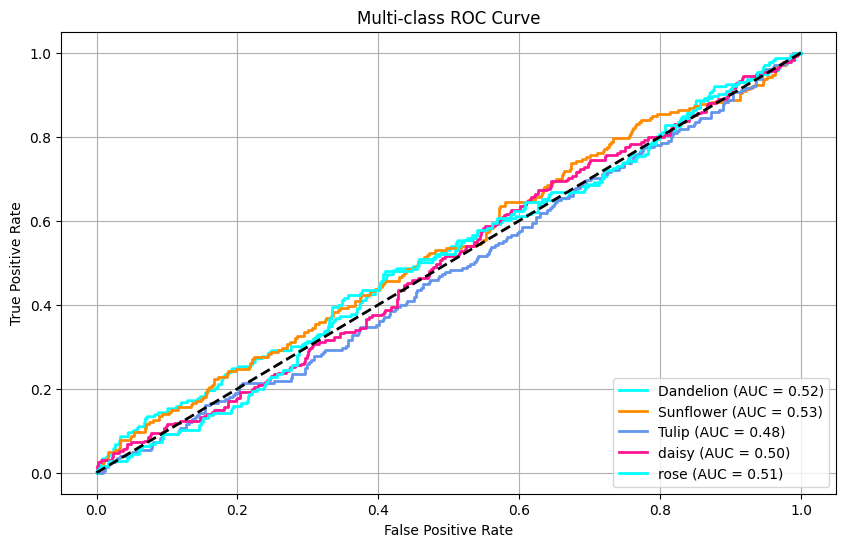

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

def plot_multiclass_roc(model, generator, class_names, title='Multi-class ROC Curve'):
    generator.reset()
    y_true = generator.classes
    y_score = model.predict(generator)

    y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
    n_classes = len(class_names)

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 6))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'deeppink'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

class_names = list(validation_generator.class_indices.keys())
plot_multiclass_roc(transfer_model, validation_generator, class_names)
